In [2]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_index >= 0 else np

# 車輪型ロボットモデル（対向2輪型）

In [4]:
class CartLayer:
    def __init__(self,batchsize=1):
        self.cart_num = batchsize
        self.pos = Variable(np.zeros( (batchsize,3), dtype=np.float32))
        self.path = Variable(np.zeros( (batchsize,1,3), dtype=np.float32))

    def move(self,param):
        if len(param) == self.cart_num:
            dx = F.reshape(param[:,0] * F.cos(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dy = F.reshape(param[:,0] * F.sin(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dth = F.reshape(param[:,1], (self.cart_num,1))
            D = F.concat((dx,dy),axis=1)
            D = F.concat((D,dth),axis=1)
            self.pos = self.pos + D
            self.path = F.concat((self.path, F.reshape(self.pos,(self.cart_num,1,3))),axis=1)
            return self.pos
        else:
            print 'len(param) != cart_num'
            return -1

# 連続で動く
def calc_car_pos(cart_layer, y):
    for step in range(len(y[0])):
        cart_layer.move(y[:,step])
    # print car.path.shape  # (4step, 50batch, 3x-y-th)
    # print car.pos.data.shape  # (50batch, 3x-y-th)
    return cart_layer.pos

# 経路の描画

In [5]:
def plot_path(cart_path,target):
    path = cart_path[:,0,:]
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   ,scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    num_step = len(target)
    plt.scatter(target[num_step-1,0],target[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.axis('scaled')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.show()

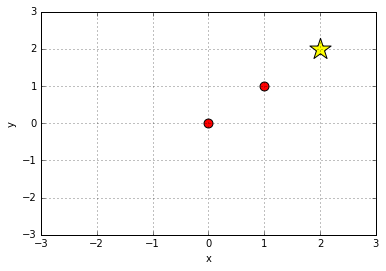

[[[0.        0.        0.       ]
  [0.8660254 0.5       0.5235988]
  [1.3660253 1.3660254 1.0471976]
  [1.3660253 2.3660254 1.5707964]]]


In [6]:
sample_v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
sample_w_arr = np.array([30.0,30.0,30.0],dtype=np.float32)
sample_w_arr = sample_w_arr * np.pi/180
sample_y_data = np.vstack((sample_v_arr,sample_w_arr)).T
sample_yV = Variable(np.reshape(sample_y_data,(1,3,2) )) 

sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,sample_yV)
plot_path(sample_cart.path.data,np.array([[0,0],[1,1],[2,2]]) )
print sample_cart.path.data


# ネットワーク

In [7]:
class ModelPathGenerator(Chain):
    def __init__(self, input_dimension, num_step):
        self.input_dim = input_dimension
        self.num_step = num_step
        initializer = initializers.HeNormal()
        super(ModelPathGenerator, self).__init__(
            l1=L.Linear(self.input_dim, 15, initialW=initializer),
            l2=L.Linear(15, 8, initialW=initializer),
            l3=L.Linear(8, self.num_step*2, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        h4 = F.tanh(h3)
        o = F.reshape(h4,(len(x),self.num_step,2))
        return o
    
    '''
    def loss_function():
        path
    
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

**入出力を確認**

In [8]:
''' sample '''
sample_model = ModelPathGenerator(2,3)
sample_x_data = np.array([[3,0]],dtype=np.float32)
sample_x = Variable(sample_x_data)
print sample_x_data
sample_y = sample_model(sample_x_data)
print sample_y
''' '''

[[3. 0.]]
variable([[[ 0.8536358  -0.85443276]
           [ 0.9726001  -0.829254  ]
           [-0.80776274 -0.9475107 ]]])


' '

### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**

# 極座標変換

[1, 1]
[1.4142135623730951, 45.0]


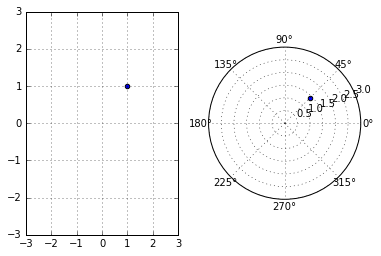

In [9]:
# 極座標変換
def to_polar_coordinate(x,y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return r,theta
# 直交座標変換
def to_cartesian_coordinate(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

sample_x,sample_y = [1,1]
sample_r,sample_theta = to_polar_coordinate(sample_x,sample_y)
print [sample_x,sample_y]
print [sample_r, sample_theta*180/np.pi]
# 直交系グラフ
ax1 = plt.subplot(1,2,1)
ax1.scatter(sample_x,sample_y)
ax1.axis([-3,3,-3,3])
ax1.grid(True)

# 極座標系グラフ
ax2 = plt.subplot(1,2,2,polar=True)
ax2.scatter(sample_theta,sample_r)
ax2.set_rmax(3)
ax2.grid(True)


# 訓練データの作成

* 極座標系で角度をランダムに指定  

\begin{equation*}
\begin{bmatrix}
0 < r < 6 \\
-\frac{π}{2} < θ < \frac{π}{2}
\end{bmatrix}
\end{equation*}

DATA_SHAPE(1000, 6)
[ 0.29007685 -1.1411438   5.945644    0.20163587  4.530824    3.392372  ]


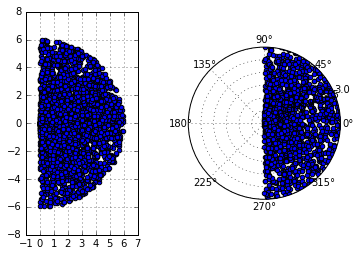

In [10]:
def random_point(size):
    # r = np.full(size, 2)
    r = np.random.rand(size) * 6
    theta = np.random.rand(size) * np.pi - (np.pi/2)
    # theta = np.random.rand(size) * 2 * np.pi - (np.pi)
    return r, theta

def generate_dataset(r,theta,plot=0):
    x,y = to_cartesian_coordinate(r,theta)
    x_data = np.vstack([x,y])
    x_data = x_data.T
    x_data = np.array(x_data, dtype=np.float32)
    if (plot>0) :
        fig1 = plt.subplot(1,2,2,polar=True)
        fig1.scatter(theta,r)
        fig1.set_rmax(3)
        fig1.grid(True)

        fig2 = plt.subplot(1,2,1)
        fig2.scatter(x,y)
        fig2.axis([-3,3,0,3])
        plt.axis('scaled')
        fig2.grid(True)
    return x_data

r, theta = random_point(1000*3)
sample_data = generate_dataset(r,theta,plot=1)

num_point = 3
sample_data = np.reshape(sample_data,(1000,num_point*2))
print 'DATA_SHAPE{}'.format(sample_data.shape)
print sample_data[0]

# 損失関数

In [11]:
def calc_distance(predict_pos,true_pos):
    #print "true_pos\n{}".format(true_pos.shape)
    #print "predict_pos\n{}".format(predict_pos.shape)
    D = F.sqrt(F.sum((true_pos-predict_pos)**2, axis=1))
    return D

# sample_p = Variable(np.array([[-0.04729605 , 3.132064, 0]], dtype=np.float32))
# sample_t = Variable(np.array([-0.9656074  ,1.9671886], dtype=np.float32))
# print calc_distance(sample_p[0,0:2],sample_t)
# 1.4833174

def velo_diff(v):
    # v (batch,3)
    V = np.zeros(len(v),dtype=np.float32)
    for i in range(len(v[0])-1):
        diff = v[:,i] - v[:,i+1]
        # print '{} = {} - {}'.format(diff, v[:,i], v[:,i+1])
        V = V + (diff*diff)
    init_v = np.zeros(len(v),dtype=np.float32)
    diff = init_v - v[:,0]
    # print '{} = {} - {}'.format(diff, init_v, v[:,0])
    V = V + diff*diff
    return V

# sample_p = Variable(np.array([[1, 1, 1], [2, 2, 2], [1, 1, 1]], dtype=np.float32) )
# print velo_diff(sample_p)

def terminal_cost(predict_terminal_position, true_terminal_position):
    p = predict_terminal_position
    t = true_terminal_position
    Loss = calc_distance(p,t)
    return Loss

def List_var2Variable(L):  # list内のVariableをF.concatで結合
    if(len(L) >= 2):
        V = F.concat((L[0],L[1]))
        for i in range(2,len(L)):
            V = F.concat((V,L[i]))
    else:
        V = L[0]
    return V

def stage_cost(predict_path, true_path):
    Loss = np.zeros(len(predict_path),dtype=np.float32)
    # print predict_path.shape
    # print true_path.shape
    if len(predict_path[0]) < 2:
        return Loss
    else:
        li_Dmin = []
        for t_pos in range( 0,len(true_path[0])-1 ): # 終点を除く
            li_D = []
            for p_pos in range( 1,len(predict_path[0])-1 ): # 始点と終点を除く
                # print 'ppos:{}'.format(predict_path[:,p_pos])
                # print 'tpos:{}'.format(true_path[:,t_pos])
                D = calc_distance(predict_path[:,p_pos], true_path[:,t_pos])  # D(batch)
                D = F.reshape(D,(len(D),1))
                li_D.append(D)
            Dvar = List_var2Variable(li_D)
            # print "Dvar\n",Dvar
            Dmin = F.min(Dvar,axis=1)
            Dmin = F.reshape(Dmin,(len(Dmin),1))
            # print "Dmin\n",Dmin
            li_Dmin.append(Dmin)
        Dmin_var =  List_var2Variable(li_Dmin)
        # print "Dmin_var\n",Dmin_var
        Loss = F.sum(Dmin_var, axis=1)
        return Loss
    
def loss_function(y, x_data):
    # y      [ batch, step,param]
    # x_data [ batch, point, x-y]
    num_step = len(y[0])
    cart = CartLayer(len(y))
    calc_car_pos(cart,y)

    # Stage cost
    predict_path = cart.path[:,:,0:2] # cart.path [ batch ,step ,x-y-th]
    true_path = x_data
    Dst = stage_cost(predict_path, true_path)

    # Terminal cost
    predict_term_pos = cart.pos[:,0:2]
    true_term_pos = x_data[:,len(x_data[0])-1]
    Dtc = terminal_cost(predict_term_pos, true_term_pos)

    # Limiting
    v = y[:,:,0]
    w = y[:,:,1]
    V = velo_diff(v)
    W = velo_diff(w)
    
    # print 'Dtc :{}'.format(Dtc)
    # print 'Dst :{}'.format(Dst)
    # print 'V :{}, v:{}'.format(V,v)
    # print 'W :{}, w:{}'.format(W,w)
    E = (10*Dtc) + (Dst) + (1*V) + (1*W)
    loss = F.mean(E)
    return loss

In [12]:
# sample_y = Variable(np.array([[[1,0], [1,0], [2,np.pi/2]], [[-1,0], [-1,0], [-2,-(np.pi/2)]]] ,dtype=np.float32 )) # 2batch 3step v-w
# sample_x = Variable(np.array([ [[1,1],[2, 2], [3,3] ]                             , [[2,2],[1,-1],[3,3] ] ] ,dtype=np.float32 )) # 2batch 2point x-y
# print loss_function(sample_y, sample_x)

# 訓練

In [15]:
def train(x_data, max_epoch, batch_size, snapshot=10):
    num_step = 9  # 台車が進む回数
    input_dim = len(x_data[0]) * 2
    model = ModelPathGenerator(num_step, input_dim)
    opt = optimizers.Adam()
    gpu_id = -1
    if gpu_id >= 0:
        model.to_gpu(gpu_id)
    train_iter = iterators.SerialIterator(x_data, batch_size)
    opt.setup(model)
    epoch = 0
    while train_iter.epoch < max_epoch:
        train_batch = np.array(train_iter.next())
        x = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        y = model(x)
        loss = loss_function(y,x)
        model.cleargrads()
        loss.backward()
        opt.update()
        epoch = epoch + 1
        if (epoch % snapshot)==0:
            print str(epoch)+": loss "+str(loss.data)
    return model

# parameter
batch_size = 10
max_epoch  = 100
snapshot = 100
# dataset
data_size  = 1000
NUM_STEP = 3
r, theta = random_point(data_size*NUM_STEP)
x_data = generate_dataset(r,theta)
x_data = np.reshape(x_data,(1000,NUM_STEP*2))
start_t = time.time()
model = train(x_data, max_epoch, batch_size, snapshot)
process_time = time.time() - start_t
print 'Time :{}'.format(process_time)

ValueError: cannot reshape array of size 60 into shape (10,2)

# 推論

In [ ]:
def predict(model, x_test, plot=0):
    x_data = Variable(x_test)
    o = model(x_data)
    car = CartLayer(len(o))
    predpos = calc_car_pos(car, o)
    truepos = Variable(x_test)
    loss = loss_function(o,predpos, truepos)
    print "loss: {}".format(loss)
    print "v,w: \n{}".format(o)
    # print car.path
    if(plot>0):
        plot_path(car.path, x_data.data[0])

sample_r     = [2]
sample_theta = [np.deg2rad(45)]
sample_x_test = generate_dataset(sample_r,sample_theta)
predict(model, sample_x_test, plot=1)

# 重みの保存と読み込み

In [ ]:
# save
def save_pretrained(model, name):
    serializers.save_npz(name, model)

save_pretrained(model, 'tmp.model')

In [ ]:
# rename model
import os
import datetime

name_date = '{0:%Y%m%d%H%M%S}'.format(datetime.datetime.now())
name_epoch = '{}epoch'.format(max_epoch)
name_batch = '{}batch'.format(batch_size)
name_datasize  = '{}data'.format(data_size)
model_name = name_datasize + name_batch + name_epoch + '_' + name_date + '.model' 
print model_name
# os.rename('tmp.model', model_name)

In [ ]:
# load
def load_pretrained(name):
    load_model = Generator()
    serializers.load_npz(name, load_model)
    return load_model

load_model = load_pretrained('tmp.model')

sample_r     = [2]
sample_theta = [np.deg2rad(0)]
sample_x_test = generate_dataset(sample_r,sample_theta)
predict(load_model, sample_x_test, plot=0)

### 2018/11/27
---
* バッチで処理 →　学習回数を増やしてデータを取る
* ネットワークを変える

### 2019/01/22 オフィスアワー 

* 次元ごとにforwordして結果を比較 
* lossを貯めて擬似的にmini-batch処理
* chainer SLAM 藤本さん qiita の記事?
* 同次変換行列ができれば...
* バッチ処理は先送りするのも検討
* 経路の途中の計算を諦めて評価値だけ天から降ってくるものとして扱う案
* NNで最適制御（普通の制御よりは複雑（非線形項））
* 前後左右の加減速（ドローンの風で安定しないなど）

### 次回までの課題
* 180度を跨がない
  - -90～90度の範囲で学習
  
* tanh (-1 ~ 1)やシグモイド(正)で無茶な加減速を抑制
  - tanh層を加えた
  - 最大速度　　:１
  - 最大角速度　:

* 学習回数を増やして結果を比較
  - 今まで1000データ 5エポック
  - 今回は1000データ 50エポック

* (できたらバッチ処理)
  - 次元ごとにforwordして結果を比較した
  - lossが怪しい

## 検証① 入力がバッチのとき・バッチでないときの結果を比較

In [ ]:
sample_input = np.array([ [2,0], [0,2], [0,-2] ], dtype=np.float32)
predict(model, sample_input)
print '\n---\n'
predict(model,np.array([[2,0]], dtype=np.float32))
predict(model,np.array([[0,2]], dtype=np.float32))
predict(model,np.array([[0,-2]], dtype=np.float32))

# 分散

In [ ]:
sample_x = [1,2,3,4]
sample_y = [1,4,9,16]
sample_error = [1,4,9,16]
def plot_error(x,y,err):
    plt.plot(x,y)
    plt.errorbar(x,y,yerr=err,ecolor='r',color='b',ls='solid',lw=2,marker='o')
    plt.show()

# plot_error(sample_x,sample_y,sample_error)

### 2019/01/29 オフィスアワー

* 損失の計算確認
  - Reshapeが間違い
  - 速度・角速度計算の入力に間違い（参照axisがおかしかった）
* 途中経路の入力（損失の計算方法を考える
  - 経由点（入力座標）を3点に変更
  - 9ステップ先まで予測
  - 

In [ ]:
def calc_distance(predpos,truepos):
    px, py, _ = predpos
    tx, ty = truepos
    print px
    print py
    print tx
    print ty
    D = F.sqrt( (tx-px)**2 + (ty-py)**2 )
    # print "p:{},{} t:{},{}  = D:{}".format(px,py,tx,ty,D)
    return D

v1 = Variable(np.array([ [[0,1,5],[0,3,2],[0,5,1],[0,8,7]],[[1,1,5],[1,3,8],[1,5,2],[1,8,7]] ],dtype=np.float32) )
v2 = Variable(np.array([ [[1,1],[2,2],[3,3]],[[2,2],[6,6],[8,8]] ],dtype=np.float32) )
# F.min( v1 , axis=1)
cv1 = F.concat( (v1[0,:,:],v1[0,:,:],v1[0,:,:]),axis=1)
tv1 = F.transpose(cv1)
print tv1
# calc_distance(tv1,tv2)
# F.transpose(v1)